## Classification modeling of rating 5.0 reviews and rating less than 5.0 reviews

### Content

- [1. Standard Imports](#1.-Standard-Imports)
- [2. Import Translated data](#2.-Import-Translated-data)
- [3. Apply PorterStemmer on reviews](#3.-Apply-PorterStemmer-on-reviews)
- [4. Train-test-split reviews](#4.-Train-test-split-reviews)
- [5. Preprocessing with CountVectorizer](#5.-Preprocessing-with-CountVectorizer)
- [6. Baseline Accuracy](#6.-Baseline-Accuracy)
- [7. Classification models](#7.-Classification-models)
 - [7.1 logistic regression](#7.1-logistic-regression)
 - [7.2 MultinomialNB Classification](#7.2-MultinomialNB-Classification)
 - [7.3 Decision Tree Classifier](#7.3-Decision-Tree-Classifier)
 - [7.4 Random Forest Classifier](#7.4-Random-Forest-Classifier)
 - [7.5 AdaBoost Classifier](#7.5-AdaBoost-Classifier)
 - [7.6 XGBoost Classifier](#7.6-XGBoost-Classifier)
- [8. Classification model Scoreboard](#8.-Classification-model-Scoreboard)
- [9. misclassified texts in Multinomial NB](#9.-misclassified-texts-in-Multinomial-NB)
- [10. Conclusion](#10.-Conclusion)

### 1. Standard Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for preprocessing reviews
from nltk.stem import PorterStemmer

# train test split, cross val score
from sklearn.model_selection import train_test_split, cross_val_score

# pipeline
from sklearn.pipeline import Pipeline

# grid search
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # they split the tree based on gini purity for classification
from sklearn.ensemble import BaggingClassifier
#this is an meta-estimator the default is DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, plot_roc_curve

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer

# to save the model
import pickle

### 2. Import Translated data

- `reviews` from Part 3 of the project is used

In [3]:
# port over the EDA df, because it is already preprocessed but not yet tokenized
df = pd.read_csv('eda_df.csv')

In [4]:
df.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language,target
0,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,really way different topics explain examples f...,By Luisa F P G,2020-05-11,5.0,73,University,5,2020,May-2020,2020-05,en,1
1,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,happy provided broad look nutritional value de...,By Liliana B,2020-06-19,5.0,61,University,6,2020,Jun-2020,2020-06,en,1


In [5]:
df['reviews'].head()

0    really way different topics explain examples f...
1    happy provided broad look nutritional value de...
2    although initiation interesting topics touched...
3    interesting videos subtitled test although ser...
4    excellent really important see introduce neces...
Name: reviews, dtype: object

In [6]:
# this is the current shape of our translated_df
print (f'shape of df is {df.shape}, there are {df.shape[0]} rows and {df.shape[1]} columns')

shape of df is (401785, 16), there are 401785 rows and 16 columns


### 3. Apply PorterStemmer on reviews

- Part 3 of the project where Exploratory Data Analysis is conducted, url links, symbols and digits are removed from `reviews`
- text in `reviews` are stemmed, where the morphological affixes from words are removed, leaving the stemmed version
- this help reduces the size of the Bag of Words

In [7]:
import regex as re
p_stemmer = PorterStemmer()

def stem_words(review):
    review_1 = re.sub("[^a-zA-Z]", " ", review).split()
    review_2 = [p_stemmer.stem(i) for i in review_1]
    return (" ".join(review_2))

In [8]:
# preprocessing the text to tokennized form
#from nltk.stem import PorterStemmer

df['reviews'] = df['reviews'].apply(stem_words)

### 4. Train-test-split reviews

- X is `reviews`
- y is `target` where `target`= 1 means `rating`=5 while `target`= 0 means `rating` less than 5
- X and y are then train_test_split into X_train, X_test, y_train, y_test

In [56]:
df.groupby(['target','rating'])[['reviews']].count()

reviews
target rating         
0      1.0        5709
       2.0        5527
       3.0       15430
       4.0       65514
1      5.0      309605

In [9]:
# Create X and y for the Classification models

X = df[['reviews']]
y = df['target']

print('X.shape : ' , X.shape)
print('y.shape  : ' , y.shape)

X.shape :  (401785, 1)
y.shape  :  (401785,)


In [10]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# checking shape of the train and test sets
print('X_train.shape : ' , X_train.shape)
print('X_test.shape  : ' , X_test.shape)
print('y_train.shape : ' , y_train.shape)
print('y_test.shape  : ' , y_test.shape)

X_train.shape :  (301338, 1)
X_test.shape  :  (100447, 1)
y_train.shape :  (301338,)
y_test.shape  :  (100447,)


In [11]:
# convert the X_train into a list
X_train_list=list()

for row in X_train['reviews']:
    X_train_list.append(row)

In [12]:
# checking
X_train_list[0:2]

['provid thank curat enough', 'pretti teacher amaz']

In [13]:
# convert the X_test into a list
X_test_list=list()

for row in X_test['reviews']:
    X_test_list.append(row)

In [14]:
# checking
X_test_list[0:2]

['aspect back rewir challeng realli transform miss last star peer grade assign meant sometim ridicul dumb rate zero even though clearli gotten answer right take help serious want pull score other wish way screen bad',
 'give valuabl howev assign way easi']

### 5. Preprocessing with CountVectorizer

- text data in `reviews` are then converted into numerical data (a matrix of token counts) using CountVectorizer
- Machine Learning Algorithms can only use numerical data
- **max_features = 4000** is used, means there are 4000 features
- **ngram_range = (1, 2)** is used, evident from EDA there are unigram and bigram that seems to differentiate target 1 and target 0 `reviews`

In [15]:
### Preprocessing with CountVectorizer
count_vec = CountVectorizer(analyzer = "word",
                             max_df= 0.9,
                             min_df= 3,
                             stop_words = None,
                             max_features = 4000,
                            ngram_range=(1, 2)
                            ) 

X_train_cv = count_vec.fit_transform(X_train_list)

In [16]:
X_test_cv = count_vec.transform(X_test_list)

In [17]:
len(count_vec.get_feature_names())

4000

In [18]:
count_vec.get_feature_names()[:10]

['abil',
 'abl',
 'abl appli',
 'abl complet',
 'abl finish',
 'abl follow',
 'abl take',
 'abl use',
 'absolut',
 'absolut amaz']

### 6. Baseline Accuracy

Classification model needs to be higher than 77%(baseline accuracy)

In [19]:
### Base line Accuracy

df['target'].value_counts(normalize=True)

1    0.770574
0    0.229426
Name: target, dtype: float64

### 7. Classification models

#### 7.1 logistic regression

In [22]:
# instantiate Logistic Regression
logreg = LogisticRegression( max_iter=10000)

# checking what are the parameters for logreg
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
# params for gridsearch
logreg_params = {'C': [0.01, 0.1 , 1],
                 'penalty': [ 'l2'],
                 'solver':['sag', 'saga']}

# 5 time cross-validation using the hyperparameters in the logreg_params
logreg_CV = GridSearchCV(logreg, logreg_params, cv=5) 

In [24]:
# fit GridSearch to training data
logreg_CV.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['sag', 'saga']})

In [25]:
# the best params/estimator from Grid Search
logreg_CV.best_estimator_

LogisticRegression(C=1, max_iter=10000, solver='saga')

In [26]:
# GridSearch accuracy score
logreg_CV.best_score_

0.8339738084772337

In [27]:
logreg_model = logreg_CV.best_estimator_

logreg_model.score(X_train_cv, y_train)

0.839173950845894

In [28]:
def model_score(model):
    print('Train Accuracy Score   :', model.score(X_train_cv, y_train))
    print('Test Accuracy Score   :', model.score(X_test_cv, y_test))
    print('Delta Between Train & Accuracy Score   :',model.score(X_train_cv, y_train) - model.score(X_test_cv, y_test) )
    
    print('------------------------------')
    
    predictions = model.predict(X_test_cv)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print("True Negatives  : %s" % tn)
    print("False Positives  : %s" % fp)
    print("False Negatives  : %s" % fn)
    print("True Positives  : %s" % tp)
    print('------------------------------')
    
     # sensitivity
    sensi = tp/(tp + fn)
    print(f'Sensitivity / True Positive Rate  : {sensi}')
    
    # false_postive_rate
    false_postive_rate = fp/(tn + fp)
    print(f'Fall-out / False Positive Rate  : {false_postive_rate}')
    
    ### plot ROC curve
    plot_roc_curve(model, X_test_cv, y_test)

Train Accuracy Score   : 0.839173950845894
Test Accuracy Score   : 0.832538552669567
Delta Between Train & Accuracy Score   : 0.006635398176326968
------------------------------
True Negatives  : 9161
False Positives  : 13882
False Negatives  : 2939
True Positives  : 74465
------------------------------
Sensitivity / True Positive Rate  : 0.962030386026562
Fall-out / False Positive Rate  : 0.6024389185435924


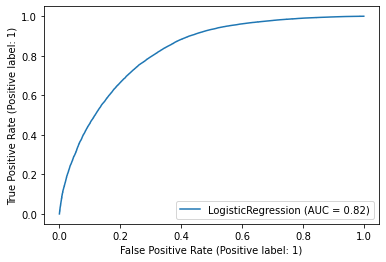

In [29]:
model_score(logreg_model)

In [28]:
filename = 'logreg_model.sav'
pickle.dump(logreg_model, open(filename, 'wb'))

In [29]:
logreg_model.coef_[0]

array([ 0.35601032,  0.25658052,  0.05690431, ..., -0.06614776,
        0.16364035, -0.15874923])

In [30]:
len(count_vec.get_feature_names())

4000

In [31]:
pd.DataFrame({'unigram/bigram': count_vec.get_feature_names(),
              'logreg coef': logreg_model.coef_[0]}).sort_values(by='logreg coef', ascending=False).head(10)

,unigram/bigram,logreg coef
3014,recommend enough,2.251682
1236,excelent,1.670241
2910,quizz exercis,1.544073
2693,phenomen,1.479121
3549,thank hope,1.362697
2252,magnific,1.348081
2770,priceless,1.332247
2293,marvel,1.331407
1175,excel,1.323187
2488,never felt,1.313332


- a one-unit presence in 'recommend enough' implies a 2.251682 unit change in the log odds of success in classifying the correct target `reviews`
- Above are the top 10 unigram/bigram that have highest log odds of success in Logistic Regression.
- We can observe that unigram/bigram like 'recommend enough', 'excelent' are **positive words**.

In [32]:
pd.DataFrame({'unigram/bigram': count_vec.get_feature_names(),
              'logreg coef': logreg_model.coef_[0]}).sort_values(by='logreg coef', ascending=True).head(10)

,unigram/bigram,logreg coef
3975,worst,-2.983904
2726,poorli,-2.615576
1715,horribl,-2.421261
2996,reason give,-2.250620
294,aw,-2.078720
2603,outdat,-1.868543
3769,useless,-1.852079
3424,superfici,-1.798839
2725,poor,-1.729227
894,disappoint,-1.620530


- a one-unit presence in 'worst' implies a -2.983904 unit change in the log odds of success in classifying the correct target `reviews`
- Above are the top 10 unigram/bigram that have lowest log odds of success in Logistic Regression.
- We can observe that unigram/bigram like 'worst', 'poorli', 'horribl' are **negative words**.

In [33]:
logreg_model = pickle.load(open('logreg_model.sav', 'rb'))

#### 7.2 MultinomialNB Classification

In [99]:
# instantiate MultinomialNB
Multi_NB = MultinomialNB()

# find what are the parameters inside
Multi_NB.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [100]:
# params for gridsearch
Multi_NB_params = {'alpha': [0.01, 0.1 , 1]}

# 5 time cross-validation using the hyperparameters in the Multi_NB_params
Multi_NB_CV = GridSearchCV(Multi_NB, Multi_NB_params, cv=5) 

In [101]:
# fitting to train set
Multi_NB_CV.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1]})

In [102]:
# finding the best params/estimator
Multi_NB_CV.best_estimator_

MultinomialNB(alpha=0.1)

In [103]:
# best score from the gridsearch
Multi_NB_CV.best_score_

0.820606757430375

In [104]:
MultiNB_model = Multi_NB_CV.best_estimator_

MultiNB_model.score(X_train_cv, y_train)

0.8218545288015451

Train Accuracy Score   : 0.8218545288015451
Test Accuracy Score   : 0.819257917110516
Delta Between Train & Accuracy Score   : 0.0025966116910290937
------------------------------
True Negatives  : 12529
False Positives  : 10514
False Negatives  : 7641
True Positives  : 69763
------------------------------
Sensitivity / True Positive Rate  : 0.9012841713606532
Fall-out / False Positive Rate  : 0.4562773944364883


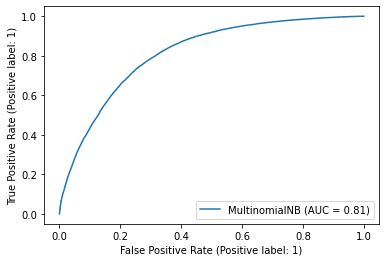

In [40]:
model_score(MultiNB_model)

In [41]:
#prob for positive class
pos_class_prob_sorted = MultiNB_model.feature_log_prob_[1, :].argsort()


#prob for negative class
neg_class_prob_sorted = MultiNB_model.feature_log_prob_[0, :].argsort()


In [42]:
pos_class_prob_sorted = MultiNB_model.feature_log_prob_[1, :].argsort()


# obtain the words 
MultiNB_count_feature = count_vec.get_feature_names()

# find top 10 words with highest coefficient with the tfidvectorizer
pd.DataFrame({'Features':MultiNB_count_feature, 
              'feature ranking':(pos_class_prob_sorted)}).sort_values(by='feature ranking', ascending=True).head(10)

,Features,feature ranking
3619,took,0
3922,whatev,1
2429,much hope,2
2315,materi present,3
931,dr charl,4
527,chunk,5
1816,instal,6
1706,hook,7
3858,warn,8
2511,ng thank,9


- These are the top 10 features that help Multinomial Naive Bayes model classify target=0 reviews and target=1 reviews
- Noticed that name of instructors were found in this top 10 list
- 'dr charl' might be refering to Dr. Charles "Chuck" Russell Severance who teaches Python for Everybody on Coursera
- 'ng thank' might be refering to Andrew Ng who teaches Machine Learning on Coursera

In [43]:
neg_class_prob_sorted = MultiNB_model.feature_log_prob_[0, :]

# obtain the words 
MultiNB_count_feature = count_vec.get_feature_names()

# find top 10 words with highest coefficient with the tfidvectorizer
pd.DataFrame({'Features':MultiNB_count_feature, 
              'feature ranking':neg_class_prob_sorted}).sort_values(by='feature ranking', ascending=True).head(10)

,Features,feature ranking
937,dr santo,-15.898101
3014,recommend enough,-15.898101
1125,ever thank,-13.500206
1343,fantast thank,-13.500206
2807,professor plou,-13.500206
2809,professor santo,-13.500206
3486,tavassoli,-12.853578
2440,much prof,-12.853578
1227,excel teach,-12.853578
2450,much wonder,-12.853578


- These are the lowest features that help Multinomial Naive Bayes model classify target=0 reviews and target=1 reviews
- Also includes other instructor's name

In [44]:
# saving the model for backup
filename = 'MultiNB_model.sav'
pickle.dump(MultiNB_model, open(filename, 'wb'))

# MultiNB_model = pickle.load(open('MultiNB_model.sav', 'rb'))

#### 7.3 Decision Tree Classifier

In [45]:
dt = DecisionTreeClassifier(max_leaf_nodes=2, max_depth=2,min_samples_split=8)
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': 2,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [46]:
dt_params = {'ccp_alpha': [0.01, 0.1 , 1], }

dt_CV = GridSearchCV(dt, dt_params, cv=5) 

In [47]:
dt.fit(X_train_cv, y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=2, min_samples_split=8)

Train Accuracy Score   : 0.7772368569513304
Test Accuracy Score   : 0.7770067796947644
Delta Between Train & Accuracy Score   : 0.00023007725656598588
------------------------------
True Negatives  : 1296
False Positives  : 21747
False Negatives  : 652
True Positives  : 76752
------------------------------
Sensitivity / True Positive Rate  : 0.9915766627047697
Fall-out / False Positive Rate  : 0.9437573232651999


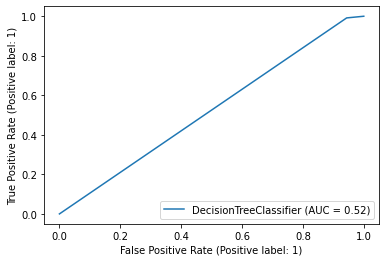

In [48]:
model_score(dt)

In [49]:
pd.DataFrame({'unigram/bigram':count_vec.get_feature_names(), 
              'feature impt':dt.feature_importances_}).sort_values(by='feature impt', ascending=False).head(5)

,unigram/bigram,feature impt
1720,howev,1.0
0,abil,0.0
2657,paul,0.0
2659,paus,0.0
2660,pay,0.0


- After much fine-tuning with Decision Tree Classifer, this model was not able to accurately classify the target=0 `reviews` from the target = 1 `reviews` as compared to other models.
- The top features ranked are not able to intuitively explain why and  false positive rate is also very high in this case.

In [50]:
# saving the model for backup
filename = 'dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))

# dt_model = pickle.load(open('dt_model.sav', 'rb'))

#### 7.4 Random Forest Classifier

In [51]:
# Instantiate Random Forest Classifer
rand_class = RandomForestClassifier()

# find the parameters inside Random Forest Classifer
rand_class.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [52]:
rand_class = RandomForestClassifier(n_estimators=100,max_leaf_nodes=2, max_depth=3,min_samples_split=2)

rand_class.fit(X_train_cv, y_train)

RandomForestClassifier(max_depth=3, max_leaf_nodes=2)

Train Accuracy Score   : 0.7705666062693719
Test Accuracy Score   : 0.7705954383903949
Delta Between Train & Accuracy Score   : -2.8832121023003587e-05
------------------------------
True Negatives  : 0
False Positives  : 23043
False Negatives  : 0
True Positives  : 77404
------------------------------
Sensitivity / True Positive Rate  : 1.0
Fall-out / False Positive Rate  : 1.0


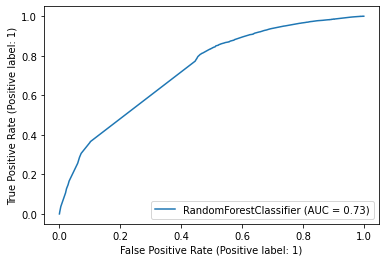

In [53]:
model_score(rand_class)

In [54]:
len(rand_class.feature_importances_)

4000

In [55]:
pd.DataFrame({'unigram/bigram':count_vec.get_feature_names(), 
              'feature impt':rand_class.feature_importances_}).sort_values(by='feature impt', ascending=False).head(10)

,unigram/bigram,feature impt
396,bit,0.07
3181,seem,0.04
2601,otherwis,0.03
1380,figur,0.03
3696,unfortun,0.03
1818,instead,0.02
1978,last,0.02
3859,wast,0.02
1558,grade,0.02
2726,poorli,0.02


- After much fine-tuning and restricting the n_estimators and max_dept of the Random Forest Classification,this model was not able to accurately classify the target=0 `reviews` from the target = 1 `reviews` as compared to other models.
- All reviews are classified as False positives and True positives only
- Also the top 10 unigram/bigram in classifying the `reviews` are not as obvious as Logistic Regression and Multinomial NB models.

In [56]:
# saving the model for backup
filename = 'rand_class.sav'
pickle.dump(rand_class, open(filename, 'wb'))

# rand_class = pickle.load(open('rand_class.sav', 'rb'))

#### 7.5 AdaBoost Classifier

In [57]:
# Instantiate the AdaBoost Classifer
ada = AdaBoostClassifier()

# find the parameters for AdaBoost Classifer
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [58]:
ada_params = {'learning_rate': [0.01, 0.1 , 1]}

ada_CV = GridSearchCV(ada, ada_params, cv=5) 

In [59]:
ada_CV.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1]})

In [60]:
ada_CV.best_estimator_

AdaBoostClassifier(learning_rate=1)

In [61]:
ada_model = ada_CV.best_estimator_

Train Accuracy Score   : 0.8068381684354445
Test Accuracy Score   : 0.805628839089271
Delta Between Train & Accuracy Score   : 0.001209329346173571
------------------------------
True Negatives  : 5808
False Positives  : 17235
False Negatives  : 2289
True Positives  : 75115
------------------------------
Sensitivity / True Positive Rate  : 0.9704278848638314
Fall-out / False Positive Rate  : 0.7479494857440437


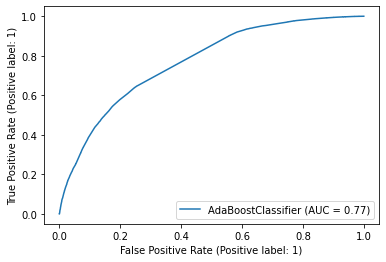

In [62]:
model_score(ada_model)

In [63]:
pd.DataFrame({'unigram/bigram':count_vec.get_feature_names(), 
              'feature impt':ada_model.feature_importances_}).sort_values(by='feature impt', ascending=False).head(10)

,unigram/bigram,feature impt
1720,howev,0.04
3530,thank,0.04
1689,highli,0.02
1339,fantast,0.02
3181,seem,0.02
1818,instead,0.02
2209,love,0.02
1092,error,0.02
3796,video,0.02
2925,rather,0.02


- AdaBoost Classifier performs much better that Descision Tree and Random Forest Classification in terms of accuracy score.
- The top 10 features in AdaBoost Classifier consists of **postive words** : 'thank', 'love', 'fantast'

In [64]:
# saving the model for backup
filename = 'ada_model.sav'
pickle.dump(ada_model, open(filename, 'wb'))

# ada_model = pickle.load(open('ada_model.sav', 'rb'))

#### 7.6 XGBoost Classifier

In [65]:
# XGBoost Classifier
XGBoost = GradientBoostingClassifier()

In [66]:
XGBoost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [67]:
xg_params = {'learning_rate': [0.01, 0.1 , 1]}

XGBoost_CV = GridSearchCV(XGBoost, xg_params, cv=5) 

In [68]:
XGBoost_CV.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1]})

In [69]:
XGBoost_CV.best_estimator_

GradientBoostingClassifier(learning_rate=1)

In [70]:
xg_model = XGBoost_CV.best_estimator_

Train Accuracy Score   : 0.8320490611871055
Test Accuracy Score   : 0.8264856093263114
Delta Between Train & Accuracy Score   : 0.0055634518607941
------------------------------
True Negatives  : 8870
False Positives  : 14173
False Negatives  : 3256
True Positives  : 74148
------------------------------
Sensitivity / True Positive Rate  : 0.9579349904397706
Fall-out / False Positive Rate  : 0.6150674825326563


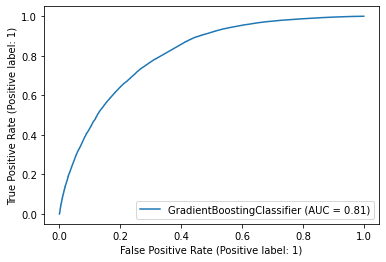

In [71]:
model_score(xg_model)

In [72]:
pd.DataFrame({'unigram/bigram':count_vec.get_feature_names(), 
              'feature impt':xg_model.feature_importances_}).sort_values(by='feature impt', ascending=False).head(10)

,unigram/bigram,feature impt
1720,howev,0.105684
3530,thank,0.088015
396,bit,0.064196
1175,excel,0.054014
233,assign,0.047997
3796,video,0.035942
3008,recommend,0.023610
3906,week,0.022254
1971,lack,0.019312
353,best,0.018377


- XGBoost Classifier model also performs much better that Descision Tree and Random Forest Classification in terms of accuracy score.
- The top 10 features in XGBoost Classifier model consists of postive words : 'thank', 'best', 'excel'

In [73]:
# saving the model for backup
filename = 'xg_model.sav'
pickle.dump(xg_model, open(filename, 'wb'))

# xg_model = pickle.load(open('xg_model.sav', 'rb'))

### 8.  Classification model Scoreboard

| Classification   model       | Train Accuracy | Test Accuracy |   Delta  | Sensitivity | Fall-out |  AUC |
|------------------------------|:--------------:|:-------------:|:--------:|-------------|----------|:----:|
| Logistic Regression          |     0.83917    |    0.83254    |  0.00664 |   0.96203   |  0.60244 | 0.82 |
| Multinomial NB               |     0.82185    |    0.81926    |  0.00260 |   0.90128   |  0.45628 | 0.81 |
| Decision Tree Classifier     |     0.77724    |    0.77701    |  0.00023 |   0.99158   |  0.94376 | 0.52 |
| Random Forest Classifier     |     0.77057    |    0.77060    | -0.00003 |      1      |     1    | 0.73 |
| Ada Boost Classifier         |     0.80684    |    0.80563    |  0.00121 |   0.97043   |  0.74795 | 0.77 |
| Gradient Boosting Classifier |     0.83205    |    0.82649    |  0.00556 |   0.95793   |  0.61507 | 0.81 |

Based on the above Classification model Scoreboard,

- All of the classification models have classification score same or better than the required Baseline Accuracy of 77%

 - `Descision Tree Classifier` & `Random Forest Classifier` performed poorly compared to other models for this dataset,
this is based on the accuracy scores are 77% and both models have high Fall-out rate (false positive rate) predict `reviews` to be mainly either False positive or True positive which predict to be target=1 `reviews`. target=0 `reviews` were not correctly classified as compared to other models. 
 - `Ada Boost Classifier` & `Gradient Boosting Classifier` both models performed better with higher accuracy scores and but the Fall-out rate is not the lowest. 
 - `Logistic Regression` & `Multinomial NB` produced high accuracy scores and ` Multinomial NB` produced the lowest Fall-out rate at 45% compared to the other models.
 
Hence, `Multinomial NB` is chosen as the best model to classify target=1 `reviews` and target=0 `reviews` for this dataset.

### 9. misclassified texts in Multinomial NB

In [19]:
MultiNB_model = pickle.load(open('MultiNB_model.sav', 'rb'))

In [115]:
pos_class_prob_sorted = MultiNB_model.feature_log_prob_[1, :].argsort()

# obtain the words 
MultiNB_count_feature = count_vec.get_feature_names()

# find top 10 words with highest coefficient with the tfidvectorizer
pd.DataFrame({'Features':MultiNB_count_feature, 
              'feature ranking':(pos_class_prob_sorted)}).sort_values(by='feature ranking', ascending=True).head(10)

,Features,feature ranking
3619,took,0
3922,whatev,1
2429,much hope,2
2315,materi present,3
931,dr charl,4
527,chunk,5
1816,instal,6
1706,hook,7
3858,warn,8
2511,ng thank,9


In [105]:
prediction = MultiNB_model.predict(X_test_cv)

# zip the array and lists 
# compare the predictions vs y_test
checking_prediction = pd.DataFrame(zip(prediction, y_test, X_test_list), columns=['prediction', 'y_test', 'X_test_list'])

# checking wrong predictions, false positives and false negatives
wrong_predictions = checking_prediction[checking_prediction['prediction'] != checking_prediction['y_test']]
wrong_predictions
# subreddit posts that are misclassified

,prediction,y_test,X_test_list
2,1,0,import deal feel happi concept environ thank
3,1,0,easili understand concept thankyou provid impo...
4,1,0,concept complet unknown eg etc holist combin a...
32,0,1,opinion video also pdf realli use methank provid
35,1,0,thadeu patient sound rush explain complet prac...
...,...,...,...
100408,0,1,suffici overview use jupyt notebook
100415,1,0,realli enjoy set organ spent wish level detail...
100427,1,0,help done graphic gcse current level taught li...
100429,1,0,learn ton suggest video graphic par thank


In [106]:
# find out the frequency of words like 

dictionary_of_words = dict()

for sentence in wrong_predictions['X_test_list']:
    for word in sentence.split():
        if word not in dictionary_of_words:
            dictionary_of_words[word] = 1
        else:
            dictionary_of_words[word] += 1

pd.DataFrame(dictionary_of_words.items(), columns=['word in misclassified posts', 'count']).sort_values(by='count',ascending=False).head(10)

,word in misclassified posts,count
49,realli,2409
50,use,2312
93,like,2146
6,thank,1924
94,lot,1877
91,assign,1857
58,help,1801
46,video,1683
72,interest,1555
62,much,1340


 - On observing the word frequency in texts that are misclassified as target=1 `reviews` where `rating` = 5.0, these high frequency words also appear in the actual target=1 `review` hence many of the classification model have a high fall-out rate, with Multinomial NB having the lowest fall-out

In [108]:
wrong_predictions['length'] = [len(text) for text in wrong_predictions['X_test_list']]

# sort the reviews and try to analyse long reviews
wrong_predictions.sort_values(by='length', ascending=False).head()

,prediction,y_test,X_test_list,length
14959,0,1,journey major concept gain allow critic evalu ...,2249
83792,0,1,gave star match descript gener overview topic ...,1313
30947,0,1,amazingli help shape broad much impress inspir...,1220
61040,0,1,gener feedback ask patient lousi expect tri ex...,1041
36818,0,1,concept taught requir everi teacher kindergart...,992


In [110]:
wrong_predictions.loc[30947, 'X_test_list']

'amazingli help shape broad much impress inspir style whole learn astonish improv broadli let explain assign week dr deni ask writer quit thing gave opportun previou write childhood parent kingartin teacher help lot assign quit amaz miracl help revis write second week dr deni help focu critic read critic main habit requir critic select chapter coyl book amaz thing book also mani advic term may writer critic focu certain tri summar question evalu felt help lot gain skill requir writer quit thing describ pictur felt realli much excit evalu argu text techniqu requir quit expertis pictur evalu argument depict main pillar shape writer studi also necessari toward expertis done assign full realli felt experienc writer occas assign earli interest opinion editori newspap desir also abl opinion fulfil desir attain expertis got much import point visit teacher lectur opinion editori struggl best opinion editori articl assign share articl friend realli appreci assign reflect also revis train expert

In [112]:
wrong_predictions.loc[36818, 'X_test_list']

'concept taught requir everi teacher kindergarten materi grasp kindergartn taught teacher manag curriculum never earli wonder succinct present key concept wish avail youth fortun professor took lectur learn retent recal saw mani concept later went found freshman commun particularli lazi effort materi thoroughli knew bad habit hinder progress semest come adopt mid term thorough confus level difficulti test consequ fail test deliv bad news also deliv path recov score provid sever hour lectur learn professor offer retest question pose differ word type multipl vs short answer vs improv score significantli pass fail distribut reflect bell curv distribut interestingli tri mid term still saw failur rate expect someth requir fail prove capit wish found better way sever lectur hour commun instruct howev prove much valuabl unexpectedli failur rate term test class respond kind lectur fail term test almost drop anoth taken class encourag stay finish came treasur compliment taught anyth want'

- In the above 2 reviews, there are many **positive words**: 'improv', 'impress', 'realli', 'encourag' even though the `rating` given by the reviewers are not 5.0.
- Hence, many classification models classify these `reviews` as target=1 based on these words inside

In [113]:
def bigram_trigam_count(df, color):
    count_vec = CountVectorizer(max_features=100, ngram_range=(2,3))
    ngrams = count_vec.fit_transform(df['X_test_list'])
    count_values = ngrams.toarray().sum(axis=0)
    vocab = count_vec.vocabulary_
    df_ngram = pd.DataFrame(((k,count_values[i]) for k,i in vocab.items()),
                        columns=['Bigram/Trigram','Frequency']).sort_values(by='Frequency', ascending=False).head(10)
    
    plt.figure(figsize=(18,5))
    sns.barplot(x='Bigram/Trigram', y ='Frequency', data=df_ngram, palette = color)
    #plt.title('Top 10 words in rating not 5', fontsize=20);

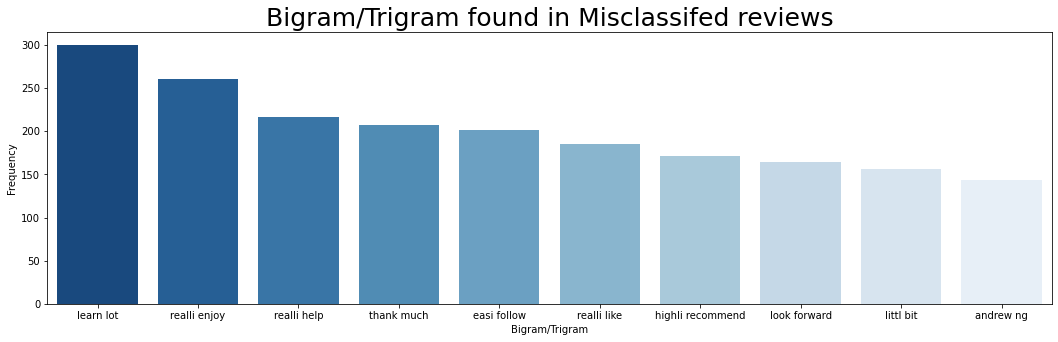

In [117]:
bigram_trigam_count(wrong_predictions, 'Blues_r')
plt.title('Bigram/Trigram found in Misclassifed reviews', fontsize = 25);

- Further analysis of the bigram/trigram of mis-classified posts, the top 10 bigram/trigram are closely similar to those of `rating`=5

### 10. Conclusion

 - `Multinomial NB` is chosen as the best model to classify target=1 `reviews` and target=0 `reviews` for this dataset as it has the lowest fall-out rate
 - From these classification models, `reviews` can be classified into target=1 `reviews` where `rating`= 5 when **positive words**: 'thank', 'recommend', 'phenomen', 'excelent' are used vice-versa when **negative words**: 'useless', 'horribl', 'poor', 'disappoint' are used.
 - There are `reviews` with less than 5.0 `rating` but the reviewers left positive words in the `reviews`, hence classification models will misclassify the post as False positives.
 - In order to improve MOOC satisfaction and based on the group of words, courses have to be 'really recommended', 'easy', reviewers feel 'thank'ful, 'realli enjoy' the material... further analysis could be done to see whether its due to the course content, instructor or difficulty level